# Petfinder.my Adoption Prediction - Kaggle

The task is to predict the speed at which a pet is adopted, based on the pet’s listing on PetFinder

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Load the data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
print('Number of training samples:', train_df.shape[0])
print('Number of test samples:', test_df.shape[0])
ratio = round( (test_df.shape[0]/train_df.shape[0]),2)
print('Train/test ratio:', (1-ratio)*100, '/', ratio*100, '%' )

Number of training samples: 14993
Number of test samples: 3948
Train/test ratio: 74.0 / 26.0 %


## Data Columns

- **PetID** - Unique hash ID of pet profile
- **AdoptionSpeed** - Categorical speed of adoption. Lower is faster. This is the value to predict.
- **Type** - Type of animal (1 = Dog, 2 = Cat)
- **Name** - Name of pet (Empty if not named)
- **Age** - Age of pet when listed, in months
- **Breed1** - Primary breed of pet (Refer to BreedLabels dictionary)
- **Breed2** - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
- **Gender** - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
- **Color1** - Color 1 of pet (Refer to ColorLabels dictionary)
- **Color2** - Color 2 of pet (Refer to ColorLabels dictionary)
- **Color3** - Color 3 of pet (Refer to ColorLabels dictionary)
- **MaturitySize** - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
- **FurLength** - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
- **Vaccinated** - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
- **Dewormed** - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
- **Sterilized** - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
- **Health** - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
- **Quantity** - Number of pets represented in profile
- **Fee** - Adoption fee (0 = Free)
- **State** - State location in Malaysia (Refer to StateLabels dictionary)
- **RescuerID** - Unique hash ID of rescuer
- **VideoAmt** - Total uploaded videos for this pet
- **PhotoAmt** - Total uploaded photos for this pet
- **Description** - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

## Full dataframe

Create a full dataframe for the analysis purposes<br>
For readability, replace the symbolic numbers with labels in the categorical fields. The labels are supplied in separated .csv files

In [5]:
full_df = pd.concat([train_df, test_df], ignore_index=True, sort=False)
full_df_numerical = full_df.copy()

color_labels = pd.read_csv('data/color_labels.csv')
breed_labels = pd.read_csv('data/breed_labels.csv')
state_labels = pd.read_csv('data/state_labels.csv')

colors = dict(zip(color_labels['ColorID'], color_labels['ColorName']))
breeds = dict(zip(breed_labels['BreedID'], breed_labels['BreedName']))
states = dict(zip(state_labels['StateID'], state_labels['StateName']))

Below lambdas are inspired by **logicalFool**'s kernel: https://www.kaggle.com/xitizzz/eda-lightgbm

In [5]:
# Adoption speed
adoptions = {0:'Same day', 1:'1st week', 2: '1st month', 3:'3 months',  4: 'Unknown'}

full_df['AdoptionSpeed'] = full_df['AdoptionSpeed'].dropna().apply(lambda x: adoptions[x])

In [6]:
# Vaccinated, dewormed and sterilized are coded as: (1 = Yes, 2 = No, 3 = Not Sure)
yes_no_notsure = {1:'Yes', 2:'No', 3:'Not sure'}

full_df['Vaccinated'] = full_df['Vaccinated'].apply(lambda x: yes_no_notsure[x])
full_df['Dewormed'] = full_df['Dewormed'].apply(lambda x: yes_no_notsure[x])
full_df['Sterilized'] = full_df['Sterilized'].apply(lambda x: yes_no_notsure[x])

In [7]:
# Health condition

healths = {1:'Healthy', 2:'Minor Injury', 3:'Serious Injury', 0:'Not Specified'}

full_df['Health'] = full_df['Health'].apply(lambda x: healths[x])

In [8]:
# Gender is (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
male_female_mixed = {1:'Male', 2:'Female', 3:'Mixed'}

full_df['Gender'] = full_df['Gender'].apply(lambda x: male_female_mixed[x])

In [9]:
# Colors

def color_lambda(x):
    if x == 0:
        return 'NA'
    if isinstance(x, (int)):
        return colors[x]
    return x


full_df['Color1'] = full_df['Color1'].apply(color_lambda)
full_df['Color2'] = full_df['Color2'].apply(color_lambda)
full_df['Color3'] = full_df['Color3'].apply(color_lambda)

In [10]:
# Breeds

def breed_lambda(x):
    if x == 0:
        return 'NA'
    if isinstance(x, (int)):
        return breeds[x]
    return x

full_df['Breed1'] = full_df['Breed1'].apply(breed_lambda)
full_df['Breed2'] = full_df['Breed2'].apply(breed_lambda)

In [11]:
# State

def state_lambda(x):
    if x == 0:
        return 'NA'
    if isinstance(x, (int)):
        return states[x]
    return x

full_df['State'] = full_df['State'].apply(state_lambda)

In [12]:
# Type

dog_cat = {1:'Dog',2:'Cat'}

def dog_cat_lambda(x):
    if isinstance(x, (int)):
        return dog_cat[x]
    return x

full_df['Type'] = full_df['Type'].apply(dog_cat_lambda)

In [13]:
# Maturity size

mat_size = {1:'Small', 2:'Medium', 3:'Large', 4:'Extra Large', 0:'Not Specified'}

full_df['MaturitySize'] = full_df['MaturitySize'].apply(lambda x: mat_size[x])

In [14]:
# Fur length

fur_lengths = {1:'Short', 2:'Medium', 3:'Long', 0:'Not Specified'}

full_df['FurLength'] = full_df['FurLength'].apply(lambda x : fur_lengths[x])

## Missing values


Drop the columns that are not relevant when making predictions. Then check if the remaining ones have missing values.

In [15]:
full_df = full_df.drop(['Name','Description','RescuerID'], axis=1)

dogs_df = full_df[full_df['Type'] == 'Dog' ]
cats_df = full_df[full_df['Type'] == 'Cat' ]

In [16]:
nan_counts = dict(full_df.isnull().sum())

nan_df = pd.DataFrame(full_df.isnull().sum(), columns=['Empty Count'])
nan_df = nan_df[nan_df['Empty Count'] != 0]
nan_df

,Empty Count
AdoptionSpeed,3948


Only **Name** and **Description** have missing values. Neither of them are revelant for predicting the adoption speed.<br>
(**AdoptionSpeed** is not present in the test csv which explains the 3948 missing values)

### Visualize the data

Plot the numerical columns as histograms:<br>
- AdoptionSpeed
- Age
- Quantity
- Fee

In [17]:
adoption_speed_order = list(adoptions.values())

### Adoption speed

Only a few pets get adopted the same day they arrive. As time passes, it gets more likely that the pet will never get adopted. Cats appear to get adopted faster than dogs.

Text(0.5, 0, 'Adoption Speed')

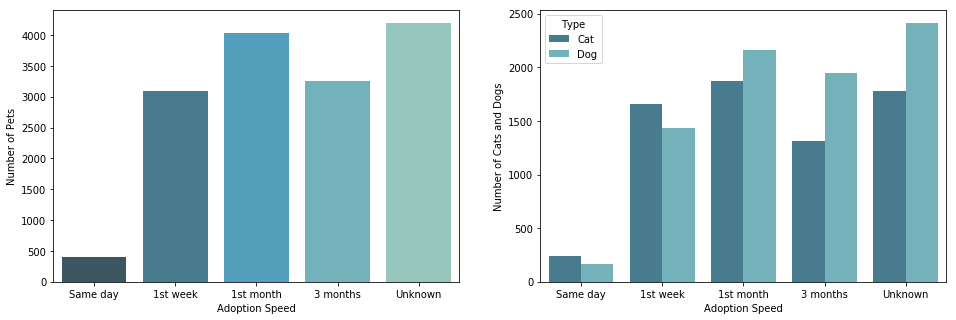

In [18]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
all_pets = sns.countplot(x="AdoptionSpeed", data=full_df, palette="GnBu_d", ax=ax[0], order=adoption_speed_order)
all_pets.set_ylabel('Number of Pets')
all_pets.set_xlabel('Adoption Speed')

cats_vs_dogs = sns.countplot(x="AdoptionSpeed", hue='Type', data=full_df, palette="GnBu_d", ax=ax[1], order=adoption_speed_order)
cats_vs_dogs.set_ylabel('Number of Cats and Dogs')
cats_vs_dogs.set_xlabel('Adoption Speed')


### Age
Pets are generally quite young, with the median age of **3 months**. <br>
Younger pets have a better chance at getting adopted.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[(0, 30)]

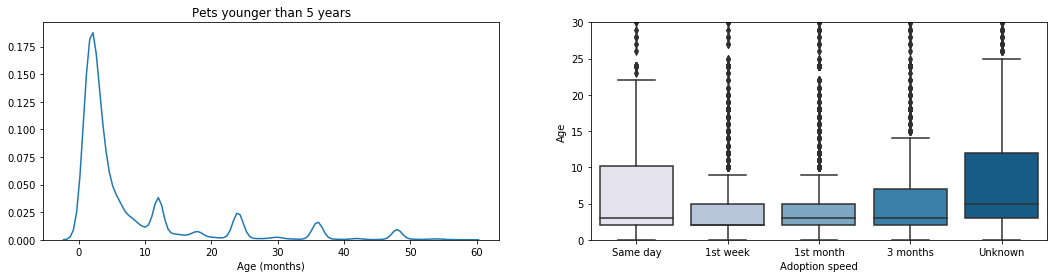

In [19]:
fig, ax = plt.subplots(1,2, figsize=(18,4))

five_years_df = full_df[full_df['Age'] < 60 ]

age_dist = sns.distplot(five_years_df['Age'], ax=ax[0], hist=False)
age_dist.set_title('Pets younger than 5 years')
age_dist.set_xlabel('Age (months)')

age_vs_speed = sns.boxplot(x="AdoptionSpeed", y="Age",order=adoption_speed_order, data=five_years_df, ax=ax[1], palette="PuBu");
age_vs_speed.set_xlabel('Adoption speed')
ax[1].set(ylim=(0, 30)) 

### Vaccination, deworming and sterilization
Most of the pets are not vaccinated or sterlized but they are dewormed.<br>
Comparing each attribute to its adoption rates, it doesn't seem to matter if these procedures are done or not. Possibly the people adopting the pets don't check, or are not aware of, these attributes?

Text(0, 0.5, 'Number of pets')

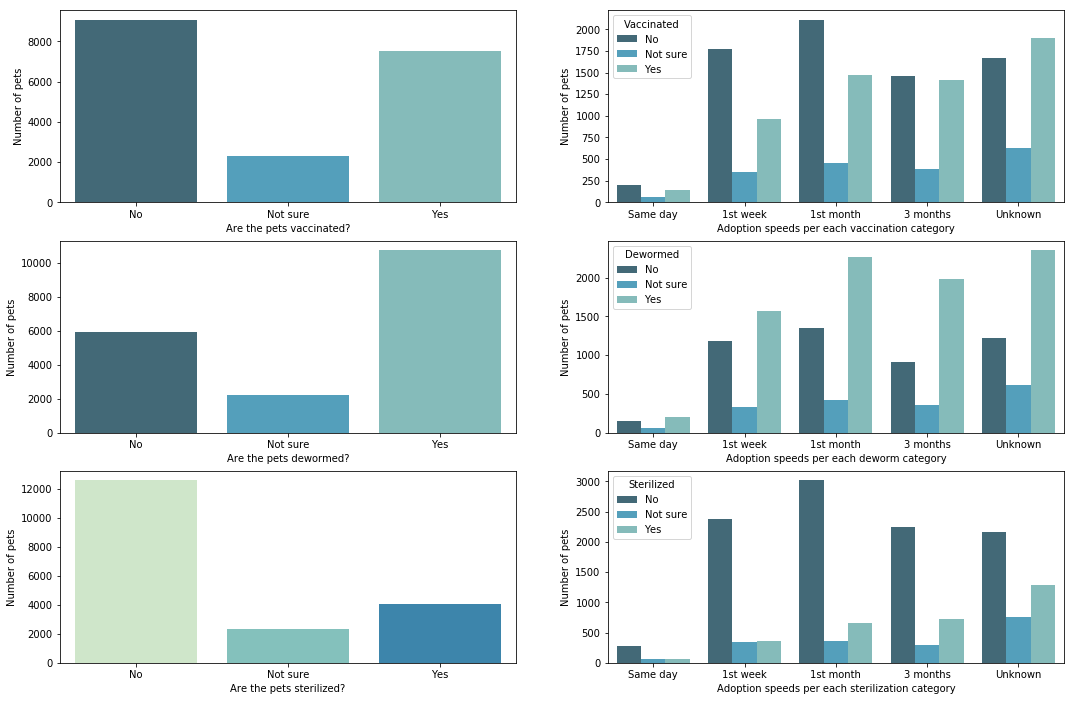

In [20]:
fig, ax = plt.subplots(3,2, figsize=(18,12))

# Vaccinated
vacc_count = sns.countplot(x='Vaccinated', data=full_df, ax=ax[0][0], palette="GnBu_d")
vacc_count.set_xlabel('Are the pets vaccinated?')
vacc_count.set_ylabel('Number of pets')

vacc_by_speed = sns.countplot(x='AdoptionSpeed', hue="Vaccinated", data=full_df, ax=ax[0][1], palette="GnBu_d", order=adoption_speed_order)
vacc_by_speed.set_xlabel('Adoption speeds per each vaccination category')
vacc_by_speed.set_ylabel('Number of pets')

# Dewormed
dew_count = sns.countplot(x='Dewormed', data=full_df, ax=ax[1][0], palette="GnBu_d")
dew_count.set_xlabel('Are the pets dewormed?')
dew_count.set_ylabel('Number of pets')

dew_by_speed = sns.countplot(x='AdoptionSpeed', hue="Dewormed",data=full_df, ax=ax[1][1], palette="GnBu_d", order=adoption_speed_order)
dew_by_speed.set_xlabel('Adoption speeds per each deworm category')
dew_by_speed.set_ylabel('Number of pets')

# Sterilized
dew_count = sns.countplot(x='Sterilized', data=full_df, ax=ax[2][0], palette="GnBu")
dew_count.set_xlabel('Are the pets sterilized?')
dew_count.set_ylabel('Number of pets')

dew_by_speed = sns.countplot(x='AdoptionSpeed', hue="Sterilized",data=full_df, ax=ax[2][1], palette="GnBu_d", order=adoption_speed_order)
dew_by_speed.set_xlabel('Adoption speeds per each sterilization category')
dew_by_speed.set_ylabel('Number of pets')

### Mixed or pure breed

Most opets are pure breed but again, it doesn't seem to affect the adoption speed.

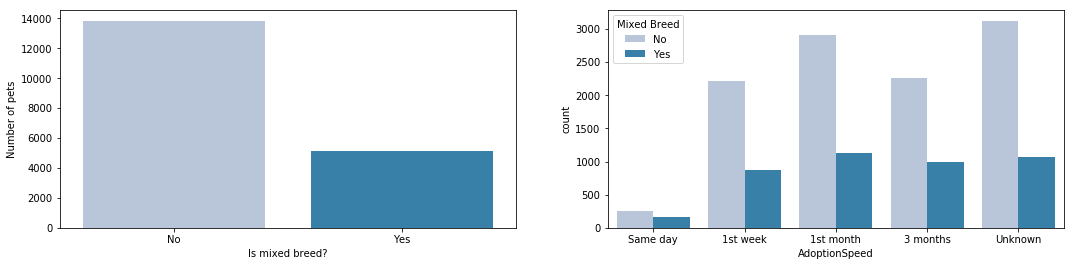

In [21]:
full_df['Mixed Breed'] = full_df.apply(lambda row: 'Yes' if row['Breed2'] != 'NA' else 'No', axis=1)

fig, ax = plt.subplots(1,2, figsize=(18,4))
is_mixed_breed = sns.countplot(x='Mixed Breed', data=full_df, ax=ax[0], palette="PuBu")
is_mixed_breed.set_xlabel('Is mixed breed?')
is_mixed_breed.set_ylabel('Number of pets')

mixed_by_adoption = sns.countplot(x='AdoptionSpeed', hue='Mixed Breed', data=full_df, palette="PuBu", order=adoption_speed_order)

### Primary color

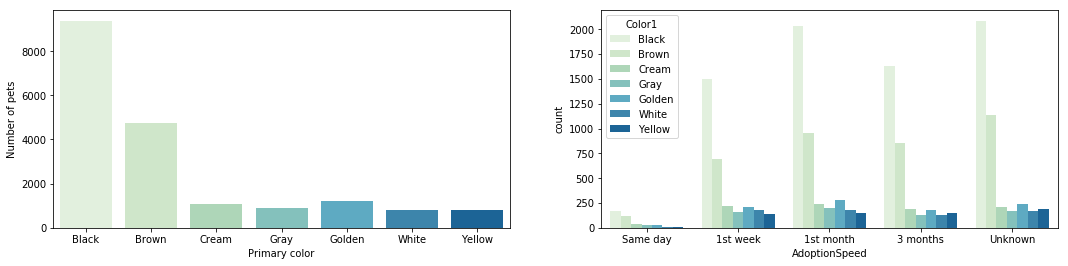

In [22]:
fig, ax = plt.subplots(1,2, figsize=(18,4))

color_count = sns.countplot(x='Color1',data=full_df, ax=ax[0], palette="GnBu")
color_count.set_xlabel('Primary color')
color_count.set_ylabel('Number of pets')

color_by_adoption = sns.countplot(x='AdoptionSpeed', hue="Color1", data=full_df, palette="GnBu", order=adoption_speed_order)

### Fee

A vast majority of the pets are **free** and the may have a sligthly higher chance of getting adopted.<br>
Those with a price tend to be quite cheap, while there's a noticeable peak at ther higher end of the price scale.

Text(0.5, 0, 'Fee')

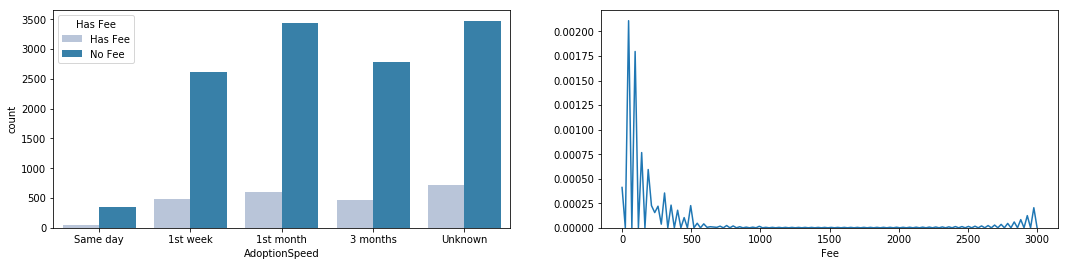

In [60]:
# Picked up the lambda below from Andrew Lukyanenko's kernel: 
# https://www.kaggle.com/artgor/exploration-of-data-step-by-step

full_fee_df = full_df.copy()
full_fee_df['Has Fee'] = full_fee_df['Fee'].apply(lambda x: 'No Fee' if x == 0 else 'Has Fee')

fig, ax = plt.subplots(1,2, figsize=(18,4))
sns.countplot(x='AdoptionSpeed', hue='Has Fee', data=full_fee_df, palette="PuBu", ax=ax[0], order=adoption_speed_order)

fee_dist = sns.distplot(full_df['Fee'], ax=ax[1], hist=False, kde=True)
fee_dist.set_xlabel('Fee')
